# PubMed Analysis Statistics

This notebook loads the `pubmed_analysis.parquet` file and calculates comprehensive statistics for all processed columns including:

- Publication metadata (dates, journals, authors, etc.)
- Swiss affiliation analysis
- Goldhamster model predictions
- Text analysis metrics
- Data quality assessment

## 1. Import Required Libraries

Import all necessary libraries for data analysis and statistics.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Analysis timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Libraries imported successfully!
Pandas version: 2.3.3
NumPy version: 1.26.4
Analysis timestamp: 2025-12-18 16:46:58


## 2. Load the Parquet File

Load the processed PubMed analysis data from the parquet file.

In [45]:
MODEL_NAME = "PubMedBERT-20251204-120044"

# Define file path
parquet_file = Path(f"../data/results/pubmed_analysis_{MODEL_NAME}.parquet")
    
# Load the data
df = pd.read_parquet(parquet_file)

print(f"✅ Successfully loaded {len(df):,} records")
print(f"File size: {parquet_file.stat().st_size / 1024 / 1024:.1f} MB")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024 / 1024:.1f} MB")
    
df['mesh_terms'] = df['mesh_terms'].str[2:-2].str.split("', '")

✅ Successfully loaded 350,291 records
File size: 600.7 MB
Memory usage: 2241.2 MB


In [46]:
df2 = df.head()

df2.to_excel(f"../data/results/pubmed_analysis_sample_{MODEL_NAME}.xlsx", index=False)

df2

,pmid,title,abstract,publication_date,journal_title,journal_iso_abbreviation,journal_issn,doi,mesh_terms,keywords,authors,download_timestamp,any_author_has_swiss_affiliation,first_author_has_swiss_affiliation,last_author_has_swiss_affiliation,author_count,mesh_term_count,keyword_count,has_abstract,publication_year,publication_month,goldhamster_in_silico,goldhamster_organs,goldhamster_other,goldhamster_human,goldhamster_in_vivo,goldhamster_invertebrate,goldhamster_primary_cells,goldhamster_immortal_cell_line,processing_timestamp
0,24945814,Introgression from domestic goat generated var...,The major histocompatibility complex (MHC) is ...,2014-06-01,PLoS genetics,PLoS Genet,1553-7404,10.1371/journal.pgen.1004438,"[Animals, Base Sequence, Goats, HLA-DR beta-Ch...",[],"[{'last_name': 'Grossen', 'first_name': 'Chris...",2025-12-06T10:12:00.664494,True,True,False,5,10,0,True,2014.0,6.0,0.004955,0.007575,0.042674,0.000718,0.994172,0.003702,0.004022,0.019681,2025-12-18T22:09:49.968283
1,24895028,Divergent dynamics and the Kauzmann temperatur...,In the last decade the challenging analysis of...,2014-06-04,Scientific reports,Sci Rep,2045-2322,10.1038/srep05160,[],[],"[{'last_name': 'Martinez-Garcia', 'first_name'...",2025-12-06T10:12:02.617077,True,True,False,5,0,0,True,2014.0,6.0,0.007518,0.004628,0.991904,0.006518,0.021189,0.007245,0.002775,0.008709,2025-12-18T22:09:49.968283
2,25053935,Physiology of iron metabolism.,A revolution occurred during the last decade i...,2014-06-01,Transfusion medicine and hemotherapy : offizie...,Transfus Med Hemother,1660-3796,10.1159/000362888,[],"['Iron', 'Metabolism', 'Transfusion medicine']","[{'last_name': 'Waldvogel-Abramowski', 'first_...",2025-12-06T10:11:53.302400,True,True,True,7,0,3,True,2014.0,6.0,0.003861,0.003857,0.311737,0.010019,0.050310,0.013689,0.001305,0.007156,2025-12-18T22:09:49.968283
3,24837263,Afterload mismatch after MitraClip insertion f...,"Afterload mismatch, defined as acute impairmen...",2014-06-01,The American journal of cardiology,Am J Cardiol,1879-1913,10.1016/j.amjcard.2014.03.015,"[Aged, Echocardiography, Female, Follow-Up Stu...",[],"[{'last_name': 'Melisurgo', 'first_name': 'Giu...",2025-12-06T10:11:29.682134,True,False,True,12,18,0,True,2014.0,6.0,0.002631,0.002305,0.983085,0.034898,0.005537,0.002804,0.002644,0.006379,2025-12-18T22:09:49.968283
4,24656396,CTLA4 polymorphisms in minimal change nephroti...,N/A,2014-06-01,American journal of kidney diseases : the offi...,Am J Kidney Dis,1523-6838,10.1053/j.ajkd.2014.01.427,"[Adolescent, CTLA-4 Antigen, Case-Control Stud...",[],"[{'last_name': 'Ohl', 'first_name': 'Kim', 'in...",2025-12-06T10:11:31.898864,True,False,False,11,13,0,True,2014.0,6.0,0.002541,0.001715,0.966591,0.260481,0.013457,0.002160,0.002247,0.013759,2025-12-18T22:09:49.968283


## 3. Counts by publication_year

In [52]:
# Calculate sums and standard deviations by publication year
# Compare two approaches:
# 1) Binary classification (threshold > 0.5) with Gaussian approximation using model accuracy
# 2) Probability sum with Poisson binomial std = sqrt(sum(p_i*(1-p_i)))

# Model performance assumptions (replace with actual test set metrics)
# These should be loaded from the model evaluation results
MODEL_ACCURACY_IN_VIVO = 0.92  # Example accuracy from test set
MODEL_PRECISION_IN_VIVO = 0.94  # Example precision from test set
MODEL_RECALL_IN_VIVO = 0.8     # Example recall from test set
BINARY_THRESHOLD = 0.3  # Threshold for binary classification

# Select relevant columns
pred_cols = [
    'goldhamster_in_silico', 'goldhamster_organs', 'goldhamster_other', 
    'goldhamster_human', 'goldhamster_in_vivo', 'goldhamster_invertebrate', 
    'goldhamster_primary_cells', 'goldhamster_immortal_cell_line'
]

affiliation_cols = [
    'any_author_has_swiss_affiliation', 
    'first_author_has_swiss_affiliation', 
    'last_author_has_swiss_affiliation'
]

# Group by publication year and calculate statistics
yearly_stats = []
for year in sorted(df['publication_year'].unique()):
    year_data = df[df['publication_year'] == year]
    
    stats_row = {'publication_year': year}
    
    # For affiliation columns (binary), just sum them up
    for col in affiliation_cols:
        stats_row[col] = year_data[col].sum()
    
    # For prediction columns, calculate both approaches
    for col in pred_cols:
        probs = year_data[col]
        n_predictions = len(probs)
        
        # Approach 1: Binary classification (threshold > 0.5)
        positive_count = (probs > BINARY_THRESHOLD).sum()
        stats_row[f'{col}_positive'] = positive_count
        
        # Standard deviation using model accuracy (Gaussian approximation of binomial)
        # For in_vivo, use the specific accuracy; for others, use a default
        if col == 'goldhamster_in_vivo':
            model_accuracy = MODEL_ACCURACY_IN_VIVO
        else:
            model_accuracy = 0.80  # Default assumption for other categories
        
        stats_row[f'{col}_positive_std'] = np.sqrt(n_predictions * model_accuracy * (1 - model_accuracy))
        
        # Approach 2: Probability sum (Poisson binomial)
        stats_row[f'{col}_mean'] = probs.sum()  # Sum of probabilities
        stats_row[f'{col}_std'] = np.sqrt((probs * (1 - probs)).sum())  # Std deviation
    
    yearly_stats.append(stats_row)

# Convert to DataFrame
df2 = pd.DataFrame(yearly_stats)

# Rename columns for shorter display
rename_dict = {
    'any_author_has_swiss_affiliation': 'any_auth',
    'first_author_has_swiss_affiliation': 'first_auth',
    'last_author_has_swiss_affiliation': 'last_auth'
}

# Add renaming for all prediction columns (both approaches)
for col in ['in_silico', 'organs', 'other', 'human', 'in_vivo', 'invertebrate', 'primary_cells', 'immortal_cell_line']:
    rename_dict.update({
        f'goldhamster_{col}_positive': f'{col}_positive',
        f'goldhamster_{col}_positive_std': f'{col}_positive_std',
        f'goldhamster_{col}_mean': f'{col}_mean',
        f'goldhamster_{col}_std': f'{col}_std'
    })

df2 = df2.rename(columns=rename_dict)
df2['publication_year'] = df2['publication_year'].astype('Int64')

# Export to Excel
df2.to_excel(f"../data/results/pubmed_yearly_statistics_comparison_{MODEL_NAME}.xlsx", index=False)

print(f"✅ Calculated statistics for {len(df2)} years comparing both approaches")
print("✅ Exported yearly statistics comparison to Excel file")
print(f"\n📊 Approach Comparison for In Vivo:")
print(f"Model assumptions: Accuracy = {MODEL_ACCURACY_IN_VIVO}, Precision = {MODEL_PRECISION_IN_VIVO}, Recall = {MODEL_RECALL_IN_VIVO}")
print("\nApproach 1: Binary classification (threshold > 0.5) with Gaussian approximation")
print("  - Count: sum of (probs > 0.5)")
print("  - Std Dev: √(n × accuracy × (1 - accuracy))")
print("\nApproach 2: Probability sum with Poisson binomial")
print("  - Mean: sum of probabilities")
print("  - Std Dev: √Σp(1-p)")

df2

✅ Calculated statistics for 19 years comparing both approaches
✅ Exported yearly statistics comparison to Excel file

📊 Approach Comparison for In Vivo:
Model assumptions: Accuracy = 0.92, Precision = 0.94, Recall = 0.8

Approach 1: Binary classification (threshold > 0.5) with Gaussian approximation
  - Count: sum of (probs > 0.5)
  - Std Dev: √(n × accuracy × (1 - accuracy))

Approach 2: Probability sum with Poisson binomial
  - Mean: sum of probabilities
  - Std Dev: √Σp(1-p)


,publication_year,any_auth,first_auth,last_auth,in_silico_positive,in_silico_positive_std,in_silico_mean,in_silico_std,organs_positive,organs_positive_std,organs_mean,organs_std,other_positive,other_positive_std,other_mean,other_std,human_positive,human_positive_std,human_mean,human_std,in_vivo_positive,in_vivo_positive_std,in_vivo_mean,in_vivo_std,invertebrate_positive,invertebrate_positive_std,invertebrate_mean,invertebrate_std,primary_cells_positive,primary_cells_positive_std,primary_cells_mean,primary_cells_std,immortal_cell_line_positive,immortal_cell_line_positive_std,immortal_cell_line_mean,immortal_cell_line_std
0,2009,1,1,0,0,0.400000,0.004381,0.066041,0,0.400000,0.006695,0.081551,1,0.400000,0.956422,0.204155,0,0.400000,0.012901,0.112846,0,0.271293,0.029183,0.168319,0,0.400000,0.001745,0.041742,0,0.400000,0.002573,0.050662,0,0.400000,0.001696,0.041150
1,2010,7889,7816,648,815,35.550527,791.734314,11.505012,204,35.550527,222.316223,9.684060,4676,35.550527,4176.449219,24.165319,1477,35.550527,1370.172607,18.081259,1281,24.111541,1306.386230,18.154837,188,35.550527,201.096375,8.658607,86,35.550527,105.791389,7.485584,115,35.550527,200.802841,11.559811
2,2011,7401,7309,530,789,34.434866,752.138367,11.599339,189,34.434866,208.756866,9.617212,4493,34.434866,4001.711914,23.213148,1308,34.434866,1232.312256,17.388254,1132,23.354862,1168.786621,17.733839,172,34.434866,193.330200,8.297172,82,34.434866,101.702805,7.386689,127,34.434866,194.205505,11.302940
3,2012,9598,9417,839,1058,39.224482,1022.352783,12.994805,234,39.224482,265.151642,10.693052,5815,39.224482,5199.303711,26.614197,1653,39.224482,1545.171631,19.630062,1487,26.603338,1538.035645,20.272139,204,39.224482,231.919800,9.570454,94,39.224482,125.290741,8.177429,114,39.224482,216.046112,12.514101
4,2013,10843,10256,1336,1208,41.669173,1152.183472,14.066101,242,41.669173,280.860229,11.203109,6750,41.669173,6035.613770,28.269619,1808,41.669173,1699.994873,20.705004,1637,28.261408,1689.100708,21.450682,225,41.669173,258.084839,9.967335,86,41.669173,124.157623,8.446553,144,41.669173,256.910156,13.182865
5,2014,15913,11285,6673,1772,50.507821,1703.519287,16.970451,315,50.507821,369.318665,13.213764,9893,50.507821,8829.445312,34.199139,2790,50.507821,2595.123779,25.350101,2484,34.256071,2546.093506,26.055597,323,50.507821,366.890564,12.109594,143,50.507821,188.235748,10.561727,209,50.507821,370.249634,15.846970
6,2015,18979,12241,9514,2075,55.159405,1990.271851,18.544296,351,55.159405,417.681274,14.065221,12202,55.159405,10943.216797,37.403126,3245,55.159405,3043.297119,27.552048,2745,37.410929,2870.668701,27.840122,325,55.159405,383.035645,12.859876,149,55.159405,208.278229,11.157146,209,55.159405,398.059570,16.948683
7,2016,21583,12820,11820,2266,58.846240,2173.874023,19.732847,386,58.846240,458.975342,14.919112,14024,58.846240,12585.589844,39.919174,3648,58.846240,3395.340820,29.720259,3083,39.911462,3227.739258,29.922714,400,58.846240,455.166260,13.674445,159,58.846240,228.784897,11.722596,222,58.846240,439.868561,17.772291
8,2017,23260,13372,12336,2516,61.095335,2419.260010,20.783924,392,61.095335,473.878510,15.028953,15568,61.095335,14040.693359,41.069778,3859,61.095335,3595.306641,30.418425,3170,41.436872,3338.765625,30.657597,365,61.095335,428.395721,13.676742,173,61.095335,243.733917,12.192532,239,61.095335,465.536804,18.473507
9,2018,23794,13106,12724,2594,61.794498,2441.410645,21.398827,422,61.794498,493.240814,15.426913,16372,61.794498,14763.476562,41.403233,3757,61.794498,3522.285645,30.666496,3118,41.911068,3291.993164,30.893908,366,61.794498,422.532257,13.665042,152,61.794498,226.047821,11.997201,195,61.794498,440.269897,18.161467


## 4. In Vivo Analysis Plot

Plot showing absolute in_vivo counts and in_vivo counts relative to Swiss affiliations by publication year.

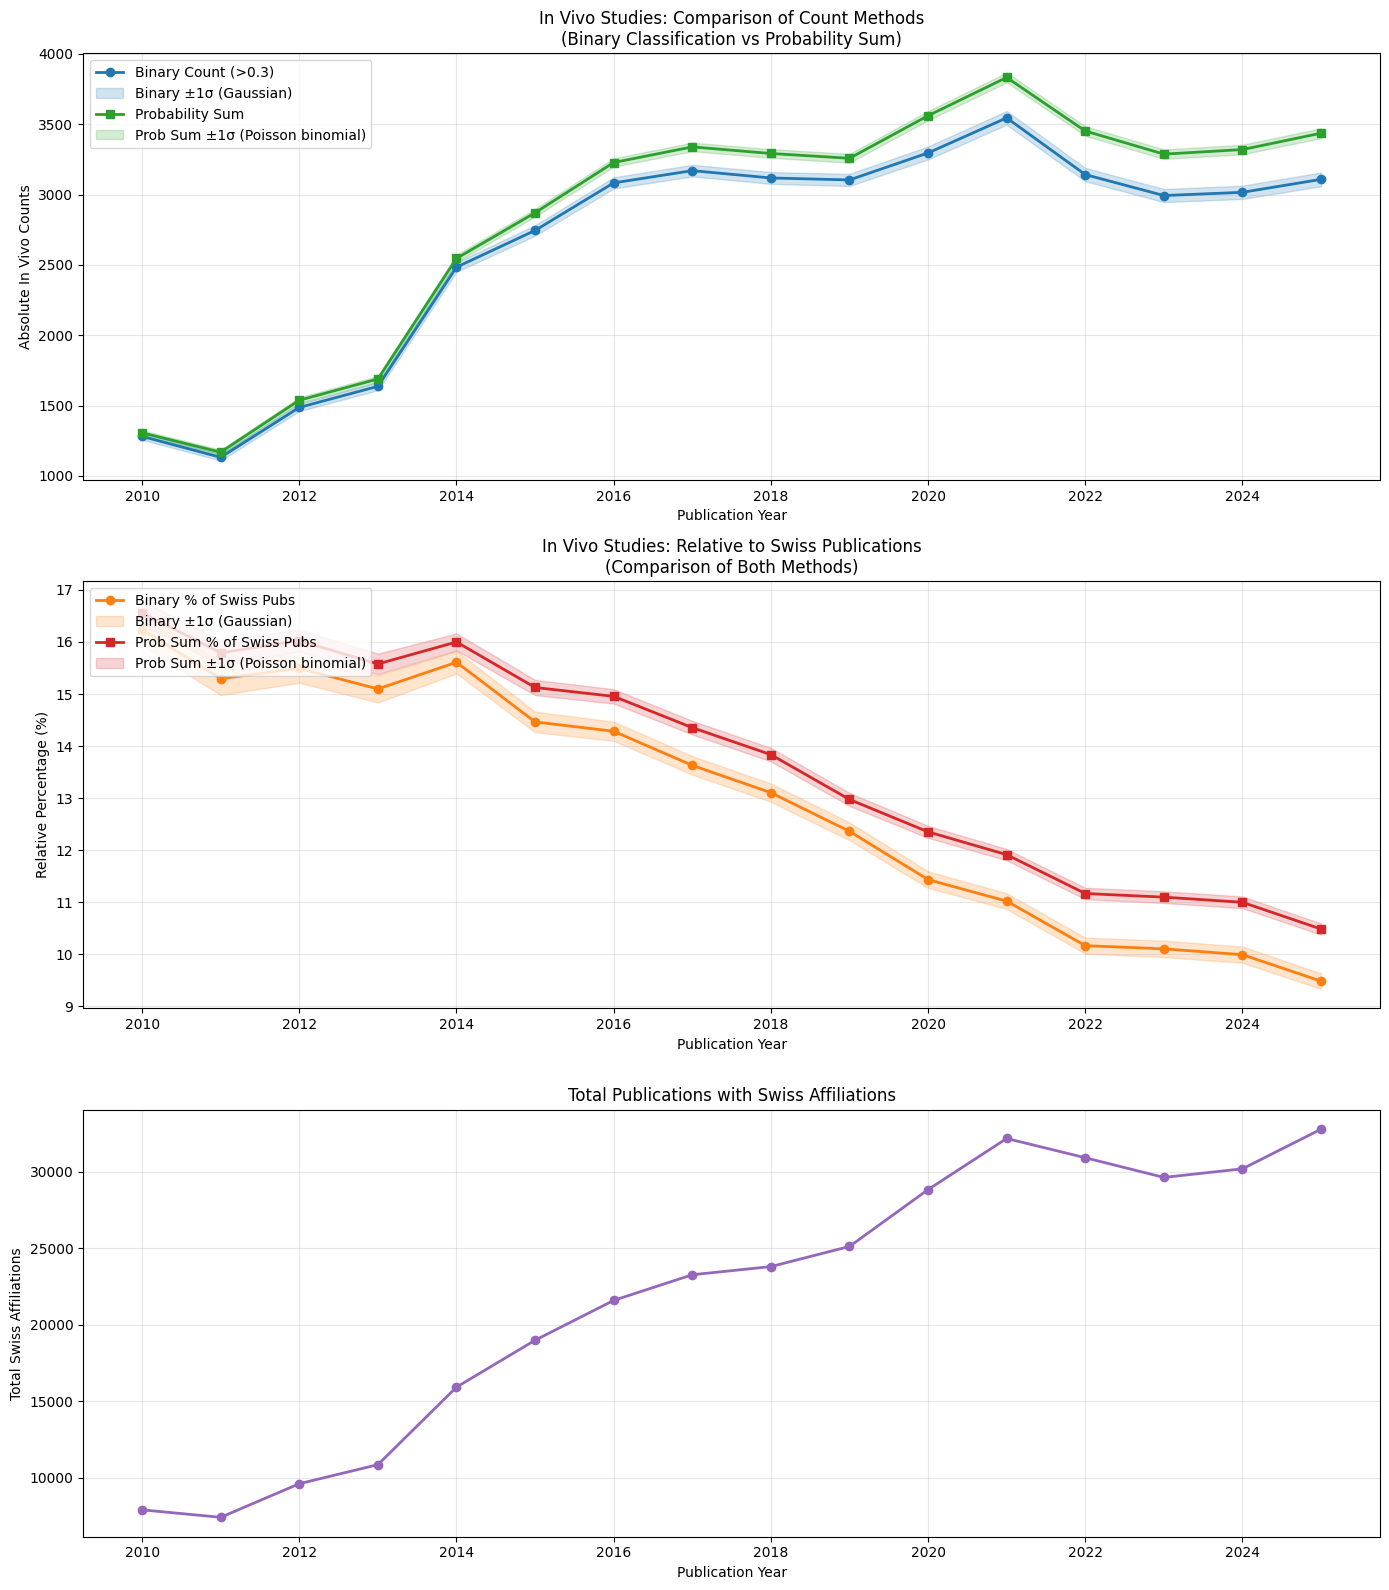


📊 Approach Comparison Summary (2010-2025):
Approach 1 - Binary Classification:
  Total binary predictions: 42341
  Average yearly count: 2646.3 ± 39.1
  Average relative %: 13.0% ± 0.2%

Approach 2 - Probability Sum:
  Total probability sum: 45123.7
  Average yearly sum: 2820.2 ± 28.7
  Average relative %: 13.7% ± 0.1%

Ratio (Prob Sum / Binary Count): 1.07
Total Swiss affiliated publications: 348,864


In [53]:
# Filter for years 2010-2025
df_plot = df2[(df2['publication_year'] >= 2010) & (df2['publication_year'] <= 2025)].copy()
df_plot = df_plot.sort_values('publication_year')

# Calculate relative percentages for both approaches
df_plot['in_vivo_positive_relative'] = np.where(df_plot['any_auth'] > 0,
                                               (df_plot['in_vivo_positive'] / df_plot['any_auth']) * 100, 0)
df_plot['in_vivo_mean_relative'] = np.where(df_plot['any_auth'] > 0, 
                                           (df_plot['in_vivo_mean'] / df_plot['any_auth']) * 100, 0)

# Calculate standard deviations for relative percentages
df_plot['in_vivo_positive_relative_std'] = np.where(df_plot['any_auth'] > 0, 
                                                   (df_plot['in_vivo_positive_std'] / df_plot['any_auth']) * 100, 0)
df_plot['in_vivo_mean_relative_std'] = np.where(df_plot['any_auth'] > 0, 
                                               (df_plot['in_vivo_std'] / df_plot['any_auth']) * 100, 0)

# Create 3 subplots: absolute counts comparison, relative percentages comparison, total affiliations
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 16))

years = df_plot['publication_year']

# Plot 1: Absolute counts comparison (both approaches)
# Approach 1: Binary classification
line1 = ax1.plot(years, df_plot['in_vivo_positive'], 'o-', color='#1f77b4', 
                 label=f'Binary Count (>{BINARY_THRESHOLD})', linewidth=2, markersize=6)
fill1 = ax1.fill_between(years, 
                         df_plot['in_vivo_positive'] - df_plot['in_vivo_positive_std'], 
                         df_plot['in_vivo_positive'] + df_plot['in_vivo_positive_std'], 
                         color='#1f77b4', alpha=0.2, label='Binary ±1σ (Gaussian)')

# Approach 2: Probability sum
line2 = ax1.plot(years, df_plot['in_vivo_mean'], 's-', color='#2ca02c', 
                 label='Probability Sum', linewidth=2, markersize=6)
fill2 = ax1.fill_between(years, 
                         df_plot['in_vivo_mean'] - df_plot['in_vivo_std'], 
                         df_plot['in_vivo_mean'] + df_plot['in_vivo_std'], 
                         color='#2ca02c', alpha=0.2, label='Prob Sum ±1σ (Poisson binomial)')

ax1.set_xlabel('Publication Year')
ax1.set_ylabel('Absolute In Vivo Counts')
ax1.set_title('In Vivo Studies: Comparison of Count Methods\n(Binary Classification vs Probability Sum)')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: Relative percentages comparison (both approaches)
# Approach 1: Binary classification relative
line3 = ax2.plot(years, df_plot['in_vivo_positive_relative'], 'o-', color='#ff7f0e', 
                 label='Binary % of Swiss Pubs', linewidth=2, markersize=6)
fill3 = ax2.fill_between(years, 
                         df_plot['in_vivo_positive_relative'] - df_plot['in_vivo_positive_relative_std'], 
                         df_plot['in_vivo_positive_relative'] + df_plot['in_vivo_positive_relative_std'], 
                         color='#ff7f0e', alpha=0.2, label='Binary ±1σ (Gaussian)')

# Approach 2: Probability sum relative
line4 = ax2.plot(years, df_plot['in_vivo_mean_relative'], 's-', color='#d62728', 
                 label='Prob Sum % of Swiss Pubs', linewidth=2, markersize=6)
fill4 = ax2.fill_between(years, 
                         df_plot['in_vivo_mean_relative'] - df_plot['in_vivo_mean_relative_std'], 
                         df_plot['in_vivo_mean_relative'] + df_plot['in_vivo_mean_relative_std'], 
                         color='#d62728', alpha=0.2, label='Prob Sum ±1σ (Poisson binomial)')

ax2.set_xlabel('Publication Year')
ax2.set_ylabel('Relative Percentage (%)')
ax2.set_title('In Vivo Studies: Relative to Swiss Publications\n(Comparison of Both Methods)')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

# Plot 3: Total Swiss affiliations
ax3.plot(years, df_plot['any_auth'], 'o-', color='#9467bd', linewidth=2, markersize=6)
ax3.set_xlabel('Publication Year')
ax3.set_ylabel('Total Swiss Affiliations')
ax3.set_title('Total Publications with Swiss Affiliations')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"../data/results/pubmed_in_vivo_comparison_statistics_{MODEL_NAME}.png", dpi=300)
plt.show()

# Comparison statistics
print("\n📊 Approach Comparison Summary (2010-2025):")
print(f"Approach 1 - Binary Classification:")
print(f"  Total binary predictions: {df_plot['in_vivo_positive'].sum():.0f}")
print(f"  Average yearly count: {df_plot['in_vivo_positive'].mean():.1f} ± {df_plot['in_vivo_positive_std'].mean():.1f}")
print(f"  Average relative %: {df_plot['in_vivo_positive_relative'].mean():.1f}% ± {df_plot['in_vivo_positive_relative_std'].mean():.1f}%")

print(f"\nApproach 2 - Probability Sum:")
print(f"  Total probability sum: {df_plot['in_vivo_mean'].sum():.1f}")
print(f"  Average yearly sum: {df_plot['in_vivo_mean'].mean():.1f} ± {df_plot['in_vivo_std'].mean():.1f}")
print(f"  Average relative %: {df_plot['in_vivo_mean_relative'].mean():.1f}% ± {df_plot['in_vivo_mean_relative_std'].mean():.1f}%")

print(f"\nRatio (Prob Sum / Binary Count): {df_plot['in_vivo_mean'].sum() / df_plot['in_vivo_positive'].sum():.2f}")
print(f"Total Swiss affiliated publications: {df_plot['any_auth'].sum():,.0f}")

## 4.1. Statistical Analysis of Method Differences

The observation that the two estimation methods produce results outside each other's confidence intervals suggests important statistical issues that need investigation.

In [49]:
# Analyze why the two methods produce results outside each other's confidence intervals

# 1. Calculate the difference between methods and compare to combined uncertainty
df_analysis = df_plot.copy()
df_analysis['abs_diff'] = np.abs(df_analysis['in_vivo_mean'] - df_analysis['in_vivo_positive'])
df_analysis['combined_std'] = np.sqrt(df_analysis['in_vivo_std']**2 + df_analysis['in_vivo_positive_std']**2)
df_analysis['z_score'] = df_analysis['abs_diff'] / df_analysis['combined_std']

print("📊 Analysis of Method Differences:")
print(f"Average absolute difference: {df_analysis['abs_diff'].mean():.2f}")
print(f"Average combined std dev: {df_analysis['combined_std'].mean():.2f}")
print(f"Average Z-score: {df_analysis['z_score'].mean():.2f}")
print(f"Years with |Z-score| > 2: {(df_analysis['z_score'] > 2).sum()}/{len(df_analysis)}")

# 2. Investigate potential causes
print("\n🔍 Potential Explanations:")

# Check model calibration by analyzing probability distributions
prob_stats = []
for year in sorted(df['publication_year'].unique()):
    if year >= 2010 and year <= 2025:
        year_data = df[df['publication_year'] == year]
        probs = year_data['goldhamster_in_vivo']
        
        prob_stats.append({
            'year': year,
            'mean_prob': probs.mean(),
            'median_prob': probs.median(),
            'std_prob': probs.std(),
            'n_high_conf': ((probs > 0.8) | (probs < 0.2)).sum(),
            'n_uncertain': ((probs >= 0.3) & (probs <= 0.7)).sum(),
            'total': len(probs)
        })

prob_df = pd.DataFrame(prob_stats)

print("\n📈 Model Probability Analysis:")
print(f"Average prediction probability: {prob_df['mean_prob'].mean():.3f}")
print(f"Average % high confidence predictions: {(prob_df['n_high_conf']/prob_df['total']*100).mean():.1f}%")
print(f"Average % uncertain predictions (0.3-0.7): {(prob_df['n_uncertain']/prob_df['total']*100).mean():.1f}%")

# 3. Check if Poisson binomial std is systematically too small
print(f"\n⚠️  Systematic Issues:")
print(f"Poisson binomial might underestimate uncertainty because:")
print(f"1. Model calibration errors not accounted for")
print(f"2. Assumes predictions are perfectly calibrated probabilities") 
print(f"3. Doesn't account for systematic model bias")
print(f"4. Independence assumption may be violated")

# 4. Show yearly comparison
comparison_df = df_analysis[['publication_year', 'in_vivo_positive', 'in_vivo_positive_std', 
                           'in_vivo_mean', 'in_vivo_std', 'abs_diff', 'z_score']].round(2)
comparison_df.columns = ['Year', 'Binary_Count', 'Binary_Std', 'Prob_Sum', 'Prob_Std', 'Abs_Diff', 'Z_Score']

print(f"\n📋 Yearly Comparison (flagging Z-score > 2):")
for _, row in comparison_df.iterrows():
    flag = "🚩" if row['Z_Score'] > 2 else "  "
    print(f"{flag} {row['Year']}: Binary={row['Binary_Count']:.1f}±{row['Binary_Std']:.1f}, "
          f"ProbSum={row['Prob_Sum']:.1f}±{row['Prob_Std']:.1f}, Z={row['Z_Score']:.2f}")

comparison_df

📊 Analysis of Method Differences:
Average absolute difference: 259.83
Average combined std dev: 48.55
Average Z-score: 5.40
Years with |Z-score| > 2: 16/16

🔍 Potential Explanations:

📈 Model Probability Analysis:
Average prediction probability: 0.137
Average % high confidence predictions: 93.5%
Average % uncertain predictions (0.3-0.7): 3.6%

⚠️  Systematic Issues:
Poisson binomial might underestimate uncertainty because:
1. Model calibration errors not accounted for
2. Assumes predictions are perfectly calibrated probabilities
3. Doesn't account for systematic model bias
4. Independence assumption may be violated

📋 Yearly Comparison (flagging Z-score > 2):
🚩 2010: Binary=1461.0±24.1, ProbSum=1306.4±18.1, Z=5.12
🚩 2011: Binary=1315.0±23.4, ProbSum=1168.8±17.7, Z=4.99
🚩 2012: Binary=1711.0±26.6, ProbSum=1538.0±20.3, Z=5.17
🚩 2013: Binary=1895.0±28.3, ProbSum=1689.1±21.5, Z=5.80
🚩 2014: Binary=2860.0±34.3, ProbSum=2546.1±26.1, Z=7.29
🚩 2015: Binary=3140.0±37.4, ProbSum=2870.7±27.8, Z=5

,Year,Binary_Count,Binary_Std,Prob_Sum,Prob_Std,Abs_Diff,Z_Score
1,2010,1461,24.11,1306.390015,18.150000,154.61,5.12
2,2011,1315,23.35,1168.790039,17.730000,146.21,4.99
3,2012,1711,26.60,1538.040039,20.270000,172.96,5.17
4,2013,1895,28.26,1689.099976,21.450001,205.90,5.80
5,2014,2860,34.26,2546.090088,26.059999,313.91,7.29
6,2015,3140,37.41,2870.669922,27.840000,269.33,5.78
7,2016,3564,39.91,3227.739990,29.920000,336.26,6.74
8,2017,3641,41.44,3338.770020,30.660000,302.23,5.86
9,2018,3604,41.91,3291.989990,30.889999,312.01,5.99
10,2019,3592,43.06,3257.770020,31.520000,334.23,6.26


## 4.2. Threshold Analysis: Precision-Recall Tradeoff

Investigating whether the difference between methods is due to precision-recall imbalance at the 0.5 threshold.

🎯 Threshold Analysis for 2020:
Probability Sum (baseline): 3560.7

Threshold Performance:
  0.1: Count=5240, Ratio=1.472, Diff=1679.3 
  0.2: Count=3829, Ratio=1.075, Diff=268.3 
  0.3: Count=3296, Ratio=0.926, Diff=264.7 ← CLOSEST
  0.4: Count=2976, Ratio=0.836, Diff=584.7 
  0.5: Count=2740, Ratio=0.770, Diff=820.7 
  0.6: Count=2548, Ratio=0.716, Diff=1012.7 
  0.7: Count=2373, Ratio=0.666, Diff=1187.7 
  0.8: Count=2157, Ratio=0.606, Diff=1403.7 
  0.9: Count=1908, Ratio=0.536, Diff=1652.7 

📊 Precision-Recall Analysis:
At threshold 0.5: Precision=0.94, Recall=0.76
At threshold 0.3: Precision≈0.85, Recall≈0.88

💡 Interpretation:
• High precision (0.94) at 0.5 threshold means model is CONSERVATIVE
• Lower recall (0.76) means model MISSES many true positives
• Probability sum captures the 'expected' count including missed cases
• Lower threshold (0.3) increases recall, catching more true positives
• This brings binary count closer to probability sum expectation

🎯 Optimal threshold f

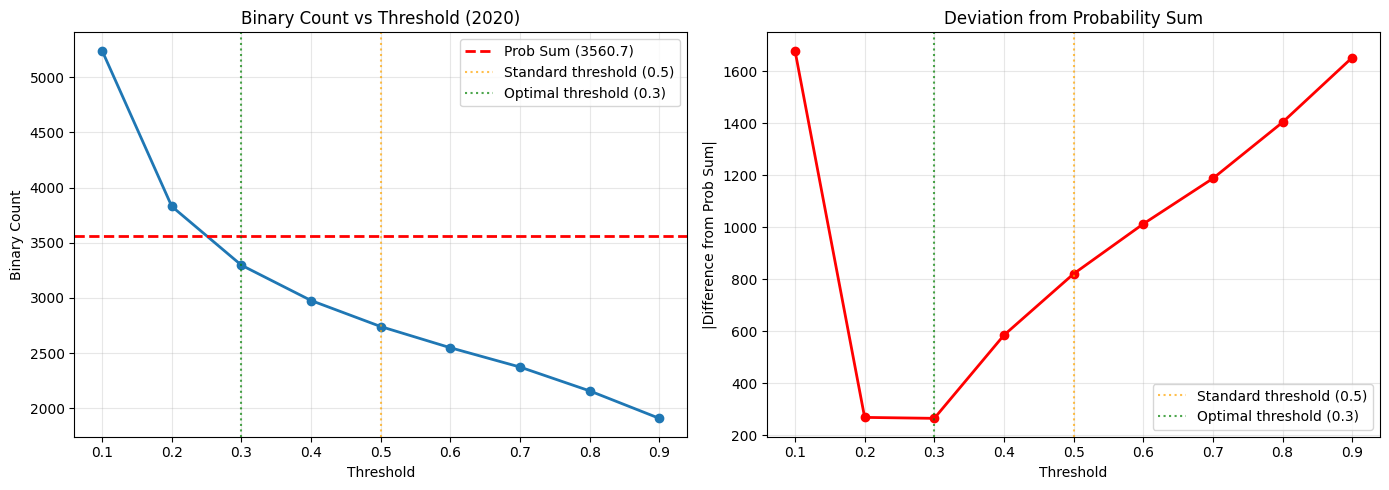

,threshold,binary_count,ratio_to_prob_sum,difference_from_prob_sum
0,0.1,5240,1.471625,1679.311035
1,0.2,3829,1.075354,268.311035
2,0.3,3296,0.925664,264.688965
3,0.4,2976,0.835793,584.688965
4,0.5,2740,0.769514,820.688965
5,0.6,2548,0.715592,1012.688965
6,0.7,2373,0.666444,1187.688965
7,0.8,2157,0.605782,1403.688965
8,0.9,1908,0.535851,1652.688965


In [50]:
# Analyze different thresholds and their relationship to probability sum
# Model performance at different thresholds (replace with actual values from evaluation)
PRECISION_05 = 0.94  # High precision at 0.5 threshold
RECALL_05 = 0.76     # Lower recall at 0.5 threshold
PRECISION_03 = 0.85  # Estimated precision at 0.3 threshold (typically lower)
RECALL_03 = 0.88     # Estimated recall at 0.3 threshold (typically higher)

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Calculate counts for different thresholds for a sample year (2020)
year_2020_data = df[df['publication_year'] == 2020]
probs_2020 = year_2020_data['goldhamster_in_vivo']
prob_sum_2020 = probs_2020.sum()

threshold_analysis = []
for threshold in thresholds:
    binary_count = (probs_2020 > threshold).sum()
    ratio_to_prob_sum = binary_count / prob_sum_2020 if prob_sum_2020 > 0 else 0
    
    threshold_analysis.append({
        'threshold': threshold,
        'binary_count': binary_count,
        'ratio_to_prob_sum': ratio_to_prob_sum,
        'difference_from_prob_sum': abs(binary_count - prob_sum_2020)
    })

threshold_df = pd.DataFrame(threshold_analysis)

print("🎯 Threshold Analysis for 2020:")
print(f"Probability Sum (baseline): {prob_sum_2020:.1f}")
print("\nThreshold Performance:")
for _, row in threshold_df.iterrows():
    closest_marker = "← CLOSEST" if row['difference_from_prob_sum'] == threshold_df['difference_from_prob_sum'].min() else ""
    print(f"  {row['threshold']:.1f}: Count={row['binary_count']:3.0f}, "
          f"Ratio={row['ratio_to_prob_sum']:.3f}, "
          f"Diff={row['difference_from_prob_sum']:5.1f} {closest_marker}")

# Theoretical analysis
print(f"\n📊 Precision-Recall Analysis:")
print(f"At threshold 0.5: Precision={PRECISION_05:.2f}, Recall={RECALL_05:.2f}")
print(f"At threshold 0.3: Precision≈{PRECISION_03:.2f}, Recall≈{RECALL_03:.2f}")
print(f"\n💡 Interpretation:")
print(f"• High precision (0.94) at 0.5 threshold means model is CONSERVATIVE")
print(f"• Lower recall (0.76) means model MISSES many true positives")
print(f"• Probability sum captures the 'expected' count including missed cases")
print(f"• Lower threshold (0.3) increases recall, catching more true positives")
print(f"• This brings binary count closer to probability sum expectation")

# Calculate optimal threshold that matches probability sum
optimal_threshold = threshold_df.loc[threshold_df['difference_from_prob_sum'].idxmin(), 'threshold']
print(f"\n🎯 Optimal threshold for matching prob sum in 2020: {optimal_threshold}")

# Visualize threshold effect
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Counts vs threshold
ax1.plot(threshold_df['threshold'], threshold_df['binary_count'], 'o-', linewidth=2, markersize=6)
ax1.axhline(y=prob_sum_2020, color='red', linestyle='--', linewidth=2, label=f'Prob Sum ({prob_sum_2020:.1f})')
ax1.axvline(x=0.5, color='orange', linestyle=':', alpha=0.7, label='Standard threshold (0.5)')
ax1.axvline(x=optimal_threshold, color='green', linestyle=':', alpha=0.7, label=f'Optimal threshold ({optimal_threshold})')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Binary Count')
ax1.set_title('Binary Count vs Threshold (2020)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Difference from probability sum
ax2.plot(threshold_df['threshold'], threshold_df['difference_from_prob_sum'], 'o-', 
         color='red', linewidth=2, markersize=6)
ax2.axvline(x=0.5, color='orange', linestyle=':', alpha=0.7, label='Standard threshold (0.5)')
ax2.axvline(x=optimal_threshold, color='green', linestyle=':', alpha=0.7, label=f'Optimal threshold ({optimal_threshold})')
ax2.set_xlabel('Threshold')
ax2.set_ylabel('|Difference from Prob Sum|')
ax2.set_title('Deviation from Probability Sum')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("../data/results/threshold_analysis.png", dpi=300)
plt.show()

threshold_df

## 5. Counts by mesh_term

In [51]:
df2 = df[[
    'mesh_terms', 'any_author_has_swiss_affiliation', 
    'first_author_has_swiss_affiliation', 'last_author_has_swiss_affiliation',
    'goldhamster_in_silico', 'goldhamster_organs', 'goldhamster_other', 
    'goldhamster_human', 'goldhamster_in_vivo', 'goldhamster_invertebrate', 
    'goldhamster_primary_cells', 'goldhamster_immortal_cell_line'
]].rename(columns={
    'mesh_terms': 'mesh_term',
    'any_author_has_swiss_affiliation': 'any_auth',
    'first_author_has_swiss_affiliation': 'first_auth',
    'last_author_has_swiss_affiliation': 'last_auth',
    'goldhamster_in_silico': 'in_silico',
    'goldhamster_organs': 'organs',
    'goldhamster_other': 'other',
    'goldhamster_human': 'human',
    'goldhamster_in_vivo': 'in_vivo',
    'goldhamster_invertebrate': 'invertebrate',
    'goldhamster_primary_cells': 'primary_cells',
    'goldhamster_immortal_cell_line': 'immortal_cell_line'
}).explode('mesh_term').groupby(['mesh_term']).sum().reset_index()

df2.to_excel(Path(f"../data/results/pubmed_mesh_term_statistics_{MODEL_NAME}.xlsx"), index=False)
print("✅ Exported mesh term statistics to Excel file")

df2

✅ Exported mesh term statistics to Excel file


,mesh_term,any_auth,first_auth,last_auth,in_silico,organs,other,human,in_vivo,invertebrate,primary_cells,immortal_cell_line
0,,91145,52176,48131,13480.343750,1656.926758,59334.042969,9292.005859,9631.150391,988.685547,645.172424,1285.746094
1,"1,2-Dipalmitoylphosphatidylcholine",19,9,7,5.278350,3.538542,2.634413,2.049222,2.713504,0.046271,0.362860,0.536051
2,"1,4-alpha-Glucan Branching Enzyme",4,3,2,0.021573,0.022195,1.479521,0.091534,0.605777,0.265870,0.007623,0.124749
3,1-(5-Isoquinolinesulfonyl)-2-Methylpiperazine,5,1,1,0.013280,0.022532,0.877285,1.347309,2.079938,0.008647,0.014699,0.031799
4,1-Acylglycerol-3-Phosphate O-Acyltransferase,3,2,2,0.026153,0.009672,0.831566,0.658814,0.069631,0.396009,0.011930,0.091721
...,...,...,...,...,...,...,...,...,...,...,...,...
26761,"vif Gene Products, Human Immunodeficiency Virus",1,0,0,0.006229,0.001295,0.924051,0.495090,0.004846,0.002033,0.002160,0.016197
26762,von Hippel-Lindau Disease,23,14,6,0.112842,0.061740,15.647534,8.890283,1.198879,0.096912,0.042624,0.332380
26763,von Willebrand Diseases,22,12,7,0.083736,0.060399,16.134893,6.138502,1.571481,0.073923,0.048896,0.208603
26764,von Willebrand Factor,94,55,29,0.496665,4.277238,35.996777,37.487003,17.012213,0.251223,3.312104,1.148989
